# Multi-modal Embedding using Multilingual CLIP (English)

## Imports and Utilities

In [1]:
from sentence_transformers import SentenceTransformer, util, models, InputExample, losses
from PIL import Image
import glob
import torch
from torch.utils.data import DataLoader
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import pandas as pd
import os
from tqdm.autonotebook import tqdm, trange
import torch
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [2]:
image_folder = 'images/'
def show_image(img_id, img_folder=image_folder):
    try:
        image_link = img_folder + img_id + '.jpg'
        plt.title("Image")
        plt.xlabel("X pixel scaling")
        plt.ylabel("Y pixels scaling")

        image = mpimg.imread(image_link)
    except:
        image_link = img_folder + img_id + '.png'
        plt.title("Image")
        plt.xlabel("X pixel scaling")
        plt.ylabel("Y pixels scaling")

        image = mpimg.imread(image_link)
    plt.imshow(image)
    plt.show()

In [3]:
import random
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [5]:
df = pd.read_csv('data/tweets_subset.csv', index_col='Unnamed: 0').reset_index()
df[df.available].head()

,index,id,skepticism,mainstream,label,text_NL,text_EN,split,available,target,unseen_images
956,956,327027443732983808,False,True,1,"RT @USER : 3D waterkaart , hoe stroomt het wat...","RT @USER : 3D water map , how the water flows ...",test,True,3_327026285966667776,1
1211,1211,375896131127218176,False,True,1,Kom naar de Wilhelminakade R'dam en klim boven...,Come to the Wilhelminakade R'dam and climb abo...,val,True,3_375896131013971968,1
1212,1212,375899134915772416,False,True,1,RT @USER : Kom naar de Wilhelminakade R'dam en...,RT @USER : Come to the Wilhelminakade R'dam an...,val,True,3_375896131013971968,1
1214,1214,375946829881278464,False,True,1,Scholieren klimmen met Jeugdwaterschap naar ni...,Students climb to the water level of their hou...,val,True,3_375946829747089408,0
1215,1215,375946961951539200,False,True,1,RT @USER : Scholieren klimmen met Jeugdwatersc...,RT @USER : Students climb to the water level o...,train,True,3_375946829747089408,0


In [6]:
# We use the original CLIP model for computing image embeddings and English text embeddings
txt_model = SentenceTransformer('clip-ViT-B-32-multilingual-v1')
img_model = SentenceTransformer('clip-ViT-B-32')
txt_tokenizer = txt_model.tokenizer
img_tokenizer = img_model._first_module().processor.tokenizer

In [7]:
def embed_documents(documents, embedding_model=txt_model, convert_to_tensor = True, verbose = False):
    """ Embed a list of n documents/words into an n-dimensional
    matrix of embeddings

    Arguments:
        documents: A list of documents or words to be embedded
        verbose: Controls the verbosity of the process

    Returns:
        Document/words embeddings with shape (n, m) with `n` documents/words
        that each have an embeddings size of `m`
    """
    truncated_docs = [truncate_document(doc) for doc in documents]
    embeddings = embedding_model.encode(truncated_docs, show_progress_bar=verbose, convert_to_tensor=convert_to_tensor)
    return embeddings

def truncate_document(document, tokenizer=txt_tokenizer):
    tokens = tokenizer.encode(document)

    if len(tokens) > 77:
        # Skip the starting token, only include 75 tokens
        truncated_tokens = tokens[1:76]
        document = tokenizer.decode(truncated_tokens)

        # Recursive call here, because the encode(decode()) can have different result
        return truncate_document(document)

    else:
        return document

In [8]:
df['text_EN_trun'] = df['text_EN'].apply(truncate_document)

In [9]:
def embed_images(images, verbose=True, batch_size=32, embedding_model=img_model, convert_to_tensor=True):
    if batch_size:
        nr_iterations = int(np.ceil(len(images) / batch_size))

        # Embed images per batch
        embeddings = []
        for i in tqdm(range(nr_iterations), disable=not verbose):
            start_index = i * batch_size
            end_index = (i * batch_size) + batch_size

            images_to_embed = [Image.open(img_name_dict[image]) if (isinstance(image, str) and not str(image)=='nan') 
                               else (Image.new('RGB', (800, 600), color = (255,255,255)) if str(image)=='nan'
                               else image) for image in images[start_index:end_index]]
            img_emb = embedding_model.encode(images_to_embed, show_progress_bar=False, convert_to_tensor=convert_to_tensor)
            embeddings.extend(img_emb.tolist())

            # Close images
            if isinstance(images[0], str):
                for image in images_to_embed:
                    image.close()
        if not convert_to_tensor:
            embeddings = np.array(embeddings)
        else:
            embeddings = torch.tensor(embeddings).to(device='cuda')
    else:
        images_to_embed = [Image.open(filepath) for filepath in images]
        embeddings = embedding_model.encode(images_to_embed, show_progress_bar=False, convert_to_tensor=convert_to_tensor)
    return embeddings

In [10]:
def return_report(labels, preds, ids=[]):
    if len(ids)==0:
        print(metrics.classification_report(labels.cpu(), preds.cpu(), digits=4))
        return metrics.classification_report(labels.cpu(), preds.cpu(), digits=4, output_dict=True)
    else:
        print(metrics.classification_report(labels[torch.tensor(list(ids))].cpu(), preds[torch.tensor(list(ids))].cpu(), digits=4))
        return metrics.classification_report(labels[torch.tensor(list(ids))].cpu(), preds[torch.tensor(list(ids))].cpu(), digits=4, output_dict=True)

def evaluate_dataset_F1(df, preds_all, device = 'cuda', val_set = 'val'):
    preds_all = preds_all.float()
    label_all = torch.tensor(np.array(df['skepticism'])).to(device).float()
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    test = df[df['split'] == 'test'].index
    image = df[df['available']].index
    unseen = df[df['unseen_images']==1].index
    
    if val_set=='val':
        temp = val.copy()
    elif val_set=='test':
        temp = test.copy()
    
    a = temp.intersection(image)
    b = temp.difference(image)
    c = temp.intersection(image).intersection(unseen)    
    
    print('Overall Dataset:')
    all_report = return_report(label_all, preds_all)
    
    print('Training Set:')
    train_report = return_report(label_all, preds_all, train)
    
    print('Validation Set:')
    val_report = return_report(label_all, preds_all, temp)
    
    print('Validation Set with both Images and Texts:')
    val_img_report = return_report(label_all, preds_all, a)
    
    print('Validation Set with only Texts:')
    val_txt_report = return_report(label_all, preds_all, b)
    
    print('Validation Set with unseen Images:')
    val_unseen_report = return_report(label_all, preds_all, c)
    
    all_acc = ((label_all==preds_all).sum()/len(preds_all)).item()*100
    train_acc = ((label_all[torch.tensor(list(train))]==preds_all[torch.tensor(list(train))]).sum()/len(train)).item()*100
    val_acc = ((label_all[torch.tensor(list(temp))]==preds_all[torch.tensor(list(temp))]).sum()/len(temp)).item()*100
    val_img_acc = ((label_all[torch.tensor(list((a)))]==preds_all[torch.tensor(list(a))]).sum()/len(a)).item()*100
    val_txt_acc = ((label_all[torch.tensor(list((b)))]==preds_all[torch.tensor(list((b)))]).sum()/len(b)).item()*100
    val_unseen = ((label_all[torch.tensor(list((c)))]==preds_all[torch.tensor(list((c)))]).sum()/len(c)).item()*100
    
    print('''
    Overall Accuracy: {:.2f}
    Training Set Accuracy: {:.2f}
    Validation Set Accuracy: {:.2f}
    Validation Set with both Images and Texts: {:.2f}
    Validation Set with only Texts: {:.2f}
    Validation Set with unseen Images: {:.2f}
    '''.format(all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen))
    
    return all_report, train_report, val_report, val_img_report, val_txt_report, val_unseen_report

In [11]:
def evaluate_dataset(df, preds_all, device = 'cuda', val_set = 'val'):
    preds_all = preds_all.float()
    label_all = torch.tensor(np.array(df['skepticism'])).to(device).float()
    #train = torch.tensor(np.array(df_all['split'] == 'train')).to(device).float()
    train = df[df['split'] == 'train'].index
    #val = torch.tensor(np.array(df_all['split'] == 'val')).to(device).float()
    val = df[df['split'] == 'val'].index
    #test = torch.tensor(np.array(df_all['split'] == 'test')).to(device).float()
    test = df[df['split'] == 'test'].index
    #image = torch.tensor(np.array(df_all['available'])).to(device).float()
    image = df[df['available']].index
    #unseen = torch.tensor(np.array(df_all['unseen_images'])).to(device).float()
    unseen = df[df['unseen_images']==1].index
    
    if val_set=='val':
        a = val.intersection(image)
        b = val.difference(image)
        c = val.intersection(image).intersection(unseen)
        val_acc = ((label_all[torch.tensor(list(val))]==preds_all[torch.tensor(list(val))]).sum()/len(val)).item()*100
            
    elif val_set=='test':
        a = test.intersection(image)
        b = test.difference(image)
        c = test.intersection(image).intersection(unseen)
        val_acc = ((label_all[torch.tensor(list(test))]==preds_all[torch.tensor(list(test))]).sum()/len(test)).item()*100
    
    all_acc = ((label_all==preds_all).sum()/len(preds_all)).item()*100
    train_acc = ((label_all[torch.tensor(list(train))]==preds_all[torch.tensor(list(train))]).sum()/len(train)).item()*100
    
    val_img_acc = ((label_all[torch.tensor(list((a)))]==preds_all[torch.tensor(list(a))]).sum()/len(a)).item()*100
    val_txt_acc = ((label_all[torch.tensor(list((b)))]==preds_all[torch.tensor(list((b)))]).sum()/len(b)).item()*100
    val_unseen = ((label_all[torch.tensor(list((c)))]==preds_all[torch.tensor(list((c)))]).sum()/len(c)).item()*100
    
    print('''
    Overall Accuracy: {:.2f}
    Training Set Accuracy: {:.2f}
    Validation Set Accuracy: {:.2f}
    Validation Set with both Images and Texts: {:.2f}
    Validation Set with only Texts: {:.2f}
    Validation Set with unseen Images: {:.2f}
    '''.format(all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen))
    
    return all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen

## Process Raw Data into Embeddings

Two sentences to compute embeddings

In [12]:
labels = ['Climate change is a very serious issue to pay attention to! We should care about climate change!', 
          'Climate change is not even a real problem to concern about! I do not believe in it!']
lab_emb = txt_model.encode(labels, convert_to_tensor=True)
empty_img_emb = embed_images(['nan'])

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
empty_img_emb.shape

torch.Size([1, 512])

In [ ]:
txt_emb = embed_documents(list(df['text_EN']), convert_to_tensor=True, verbose=True)

In [ ]:
img_emb = embed_images(list(df['target']), convert_to_tensor=True)

In [ ]:
import pickle
with open('data/CLIP_ML_EN/embeddings.pkl', "wb") as fOut:
    pickle.dump({'sentences': list(df['text_EN_trun']), 'txt_emb': txt_emb, 'img_emb': img_emb, 
                 'lab_emb': lab_emb, 'empty_img_emb': empty_img_emb}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
with open('data/CLIP_ML_EN/embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    #stored_sentences = stored_data['sentences']
    txt_emb = stored_data['txt_emb']
    img_emb = stored_data['img_emb']
    lab_emb = stored_data['lab_emb']
    empty_img_emb = stored_data['empty_img_emb']

labs = {}
labs['txt_emb'] = lab_emb
labs['img_emb'] = torch.vstack([empty_img_emb] * lab_emb.shape[0])
mul_emb = (img_emb + txt_emb)/2

## Zero-shot Classification

Using Cosine Similarity to make classification

In [17]:
def zero_shot(df_all, model_name='CLIP_ML_EN', merge = 'average', from_stored_embedding=False, pre_computed = True,
             stored_data='', embedding_model = '', val_set='val'):
    
    if from_stored_embedding:
        folder = 'model_storage/{}/embeddings.pkl'.format(model_name)
        with open(folder, "rb") as fIn:
            stored_data = pickle.load(fIn)
            #stored_sentences = stored_data['sentences']
            txt_emb = stored_data['txt_emb']
            img_emb = stored_data['img_emb']
            lab_emb = stored_data['lab_emb']
    elif pre_computed:
        stored_data = stored_data
        #stored_sentences = stored_data['sentences']
        txt_emb = stored_data['txt_emb']
        img_emb = stored_data['img_emb']
        lab_emb = stored_data['lab_emb']
    else:
        txt_emb = embed_documents(list(df_all['text_EN_trun']), embedding_model=embedding_model, convert_to_tensor=True, verbose=True)
        img_emb = embed_images(list(df_all['target']), embedding_model=embedding_model, convert_to_tensor=True, verbose=True)
        labels = ['Climate change is a very serious issue to pay attention to! We should care about climate change!', 
                  'Climate change is not even a real problem to concern about! I do not believe in it!']
        lab_emb = embedding_model.encode(labels, convert_to_tensor=True)
        with open('model_storage/CLIP/embeddings_re.pkl', "wb") as fOut:
            pickle.dump({'sentences': list(df['text_EN_trun']), 'txt_emb': txt_emb, 'img_emb': img_emb, 'lab_emb': lab_emb}, fOut, protocol=pickle.HIGHEST_PROTOCOL)
    
    if merge == 'average':
        mul_emb = (img_emb + txt_emb)/2
    elif merge == 'max':
        mul_emb = torch.max(img_emb, txt_emb)
    else:
        print("'Merger' input must be one of 'average' or 'max'")
    
    TXT_LAB = util.cos_sim(lab_emb, txt_emb)
    IMG_LAB = util.cos_sim(lab_emb, img_emb)
    MUL_LAB = util.cos_sim(lab_emb, mul_emb)
    
    pred_TXT = torch.argmax(TXT_LAB[:2,:], dim=0).float()
    pred_IMG = torch.argmax(IMG_LAB[:2,:], dim=0).float()
    pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
    
    lab = torch.tensor(np.array(df_all['skepticism'])).to('cuda').float()
    
    set_seed_everywhere(42, cuda=True)
    lab_rand = (torch.rand(len(lab))>0.5).float().to('cuda')
    
    print('Using textual embedding only:')
    evaluate_dataset(df_all, pred_TXT, val_set=val_set)
    
    print('Using image embedding only:')
    evaluate_dataset(df_all, pred_IMG, val_set=val_set)
    
    print('Using multi-modal embedding:')
    evaluate_dataset(df_all, pred_MUL, val_set=val_set)
    
    print('Comparing to a random prediction:')
    evaluate_dataset(df_all, lab_rand, val_set=val_set)
    
    print('Test set performance multi-modal:')
    evaluate_dataset(df_all, pred_MUL, val_set='test')
    
    return

In [18]:
zero_shot(df, stored_data = stored_data)

Using textual embedding only:

    Overall Accuracy: 61.75
    Training Set Accuracy: 61.87
    Validation Set Accuracy: 62.00
    Validation Set with both Images and Texts: 69.39
    Validation Set with only Texts: 60.64
    Validation Set with unseen Images: 64.18
    
Using image embedding only:

    Overall Accuracy: 44.69
    Training Set Accuracy: 44.82
    Validation Set Accuracy: 45.17
    Validation Set with both Images and Texts: 59.83
    Validation Set with only Texts: 42.47
    Validation Set with unseen Images: 61.28
    
Using multi-modal embedding:

    Overall Accuracy: 49.91
    Training Set Accuracy: 49.93
    Validation Set Accuracy: 50.62
    Validation Set with both Images and Texts: 68.70
    Validation Set with only Texts: 47.29
    Validation Set with unseen Images: 67.49
    
Comparing to a random prediction:

    Overall Accuracy: 49.64
    Training Set Accuracy: 49.67
    Validation Set Accuracy: 49.99
    Validation Set with both Images and Texts: 48.09
   

## Training an additional MLP

In [19]:
from argparse import Namespace
args = Namespace(
    # Data and Path information
    model_state_file='MLP_classifier.pth',
    save_dir='model_storage/CLIP_ML_EN/',
    result_dir='results/CLIP_ML_EN/',
    embedding_size=512,
    early_stopping_criteria=20,
    num_epochs=20,
    seed=42,
    
    # Training hyper parameters
    batch_size=32,
    embedding_type='text',
    fusion_type='average',
    hidden_dim=128, 
    learning_rate=5e-5,
    l2=1e-5,
    dropout_p=0.1,
    
    # Runtime options
    catch_keyboard_interrupt=True,
    device= 'cuda',
    cuda=True,
    verbose=True,
)

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class MLPClassifier(nn.Module):
    
    def __init__(self, embedding_size, embedding_type, fusion_type, hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            embedding_type (str): type of embedding to be used, can be one of {'text', 'image', 'multi'}
            fusion_type (str): type of fusing multimodal embeddings if embedding_type=='multi', can be one of 
                                {'average', 'concat', 'complex'}
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained embeddings
            
        """
        super(MLPClassifier, self).__init__()

        self.embedding_type = embedding_type
        self.fusion_type = fusion_type
        self._dropout_p = dropout_p
        self.dropout = nn.Dropout(dropout_p)
        #self.prelu = nn.PReLU()
        
        self.fc1 = nn.Linear(embedding_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
        self.fc_concat = nn.Linear(2*embedding_size, hidden_dim)
        self.fc_complex = nn.Linear(5*embedding_size, 2*embedding_size)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (dictionary): a dictionary of input data tensors with embeddings. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # embed and permute so features are channels
        x_embedded = x_in
                
        # logistic regression
        if (not self.embedding_type=='multi') or self.fusion_type=='average':
            intermediate_vector = F.relu(self.dropout(self.fc1(x_embedded)))
            prediction_vector = self.fc2(intermediate_vector)
        elif self.embedding_type=='multi' and self.fusion_type=='concat':
            intermediate_vector = F.relu(self.dropout(self.fc_concat(x_embedded)))
            prediction_vector = self.fc2(intermediate_vector)
        elif self.embedding_type=='multi' and self.fusion_type=='complex':
            first_vector = F.relu(self.dropout(self.fc_complex(x_embedded)))
            intermediate_vector = F.relu(self.dropout(self.fc_concat(first_vector)))
            prediction_vector = self.fc2(intermediate_vector)
        
        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [21]:
class CustomDataset(Dataset):
    def __init__(self, df_all, embeddings):
        self.df = df_all
        self.labels = torch.tensor(np.array(self.df['skepticism'])).to(args.device).float()
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, self.df.text_EN_trun)) + 0
        self.embeddings = embeddings
        
        train = torch.tensor(df[df['split'] == 'train'].index)
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.train_emb = self.embeddings[train]
        
        val = torch.tensor(df[df['split'] == 'val'].index)
        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)
        self.val_emb = self.embeddings[val]
                
        test = torch.tensor(df[df['split'] == 'test'].index)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.test_emb = self.embeddings[test]

        self._lookup_dict = {'train': (self.train_df, self.train_size, self.train_emb),
                             'val': (self.val_df, self.validation_size, self.val_emb),
                             'test': (self.test_df, self.test_size, self.test_emb)}

        self.set_split('train')
            
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size, self._target_emb = self._lookup_dict[split]
        
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        if len(self) % batch_size==0:
            return len(self) // batch_size
        else:
            return len(self) // batch_size + 1

    def __len__(self):
        return self._target_size

    def __getitem__(self, idx):
        emb = self._target_emb[idx].to(args.device)
        row = self._target_df.iloc[idx]
        label = torch.tensor(row[['mainstream', 'skepticism']].astype(int)).to(args.device)
        
        return {'emb': emb, 
                'label': label}

In [22]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_1_acc_val': 0,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'golden_loss': [],
            'train_loss': [],
            'train_1_acc': [],
            'train_acc': [],
            'val_loss': [],
            'val_1_acc': [],
            'val_acc': [],
            'val_img_txt': [],
            'val_txt_only': [],
            'val_unseen_img': [],
            'test_loss': -1,
            'test_1_acc': -1,
            'test_acc': -1,
            'test_img_txt': -1,
            'test_txt_only': -1,
            'test_unseen_img': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file)
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        acc_tm1, acc_t = train_state['val_1_acc'][-2:]

        # If accuracy worsened
        if acc_t <= train_state['early_stopping_best_1_acc_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if acc_t > train_state['early_stopping_best_1_acc_val']:
                train_state['early_stopping_best_1_acc_val'] = acc_t
                torch.save(model.state_dict(), args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file)
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [23]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [24]:
def softmax_sensitive(T):
    T = np.exp(T) - np.exp(0) + 1e-9
    if len(T.shape)==1:
        return T/T.sum()
    return  T/(T.sum(axis=1).unsqueeze(1))

def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = args.device
    return torch.from_numpy(df.values).float().to(device)

In [25]:
def prepare_embedding(embeddings, embedding_type, fusion_type):
    '''
    Args:
        embeddings (dictionary): a dictionary of input data tensors with embeddings. 
        embedding_type (str): type of embedding to be used, can be one of {'text', 'image', 'multi'}
        fusion_type (str): type of fusing multimodal embeddings if embedding_type=='multi', can be one of 
                        {'average', 'concat', 'complex'}'''
    if embedding_type=='text':
        x_embedded = embeddings['txt_emb']
    elif embedding_type=='image':
        x_embedded = embeddings['img_emb']
    elif embedding_type=='multi':
        if fusion_type=='average':
            x_embedded = (embeddings['txt_emb']+embeddings['img_emb'])/2
        elif fusion_type=='concat':
            x_embedded = torch.hstack([embeddings['txt_emb'], embeddings['img_emb']])
        elif fusion_type=='complex':
            txt_emb = embeddings['txt_emb']
            img_emb = embeddings['img_emb']
            x_embedded = torch.hstack([txt_emb, img_emb, txt_emb+img_emb, txt_emb-img_emb, txt_emb*img_emb])
        else:
            print('fusion_type is not supported')
    else:
        print('embedding_type is not supported')
        
    return x_embedded

In [26]:
def initialization(df, stored_data):
    set_seed_everywhere(args.seed, args.cuda)
    embeddings = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
    dataset = CustomDataset(df, embeddings)
    
    classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
    
    return embeddings, dataset, classifier

In [27]:
def write_train_state_evaluation(classifier, embeddings, train_state, df):
    preds_all = classifier(embeddings).argmax(dim=1)
    _, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen = evaluate_dataset(df, preds_all)
    
    train_state['train_acc'].append(train_acc)
    train_state['val_acc'].append(val_acc)
    train_state['val_img_txt'].append(val_img_acc)
    train_state['val_txt_only'].append(val_txt_acc)
    train_state['val_unseen_img'].append(val_unseen)
    
    return train_state

In [28]:
def training_loop(df, stored_data, labs=None, verbose=True):
    
    embeddings, dataset, classifier = initialization(df, stored_data)
    if labs:
        lab_embeddings = prepare_embedding(labs, args.embedding_type, args.fusion_type)
    classifier = classifier.to(args.device)

    loss_func = cross_entropy
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=args.l2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                               mode='min', factor=0.5,
                                               patience=1)
    train_state = make_train_state(args)
    
    print('Using {} embedding with {} fusion method'.format(args.embedding_type, args.fusion_type))
    
    set_seed_everywhere(args.seed, cuda=True)
    train_state = write_train_state_evaluation(classifier, embeddings, train_state, df)
    
    set_seed_everywhere(args.seed, cuda=True)
    try:
        for epoch_index in trange(args.num_epochs, desc="Epoch", disable=not args.verbose):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on
            dataset.set_split('train')
            train_dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
            
            running_loss = 0.0
            running_1_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(train_dataloader):

                # step 1. zero the gradients
                optimizer.zero_grad()

                # step 2. get the data compute fuzzy labels
                X = batch_dict['emb']
                y = batch_dict['label']

                size = y.shape[0]

                # step 3. compute the output
                y_pred = classifier(X)

                # step 4. compute the loss
                loss = loss_func(y_pred, y)
                loss_t = loss.item()

                running_loss = (running_loss * batch_index * args.batch_size + loss_t * size)/(batch_index * args.batch_size + size)
                
                # step 5. use loss to produce gradients
                loss.backward()

                # step 6. use optimizer to take gradient step
                optimizer.step()

                # -----------------------------------------
                # compute the accuracies
                acc_1_t = compute_1_accuracy(y_pred, y)
                running_1_acc = (running_1_acc * batch_index * args.batch_size + acc_1_t * size)/(batch_index * args.batch_size + size)
            
            if labs:
                optimizer.zero_grad()
                y_pred = classifier(lab_embeddings)
                y = torch.tensor([[1,0], [0,1]]).to(args.device)
                loss = loss_func(y_pred, y)
                loss.backward()
                optimizer.step()
                train_state['golden_loss'].append(loss.item())
            else:
                train_state['golden_loss'].append('not implemented')
            
            train_state['train_loss'].append(running_loss)
            train_state['train_1_acc'].append(running_1_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on

            dataset.set_split('val')
            val_dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

            running_loss = 0.0
            running_1_acc = 0.0
            classifier.eval()

            for batch_index, batch_dict in enumerate(val_dataloader):

                # step 2. get the data compute fuzzy labels
                X = batch_dict['emb']
                y = batch_dict['label']
                size = y.shape[0]

                # step 3. compute the output
                y_pred = classifier(X)

                # step 4. compute the loss
                loss = loss_func(y_pred, y)
                loss_t = loss.item()
                running_loss = (running_loss * batch_index * args.batch_size + loss_t * size)/(batch_index * args.batch_size + size)

                # -----------------------------------------
                # compute the accuracies
                acc_1_t = compute_1_accuracy(y_pred, y)
                running_1_acc = (running_1_acc * batch_index * args.batch_size + acc_1_t * size)/(batch_index * args.batch_size + size)

            train_state['val_loss'].append(running_loss)
            train_state['val_1_acc'].append(running_1_acc)

            train_state = write_train_state_evaluation(classifier, embeddings, train_state, df)
            
            print('Current Running Accuracy Training Set: {:.2f}, Validation Set: {:.2f}, Golden Set: {:.2f}'.format(train_state['train_1_acc'][-1], train_state['val_1_acc'][-1], train_state['golden_loss'][-1]))

            train_state = update_train_state(args=args, model=classifier, train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break

            with open(args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + 'train_state.p', 'wb') as fp:
                pickle.dump(train_state, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

In [29]:
def experiment(df, stored_data, labs = None, hyperdict={}):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    
    for key in combi:
        print(key)
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        if not key in hyperdict:
            train_state = training_loop(df, stored_data, labs=labs)
            hyperdict[key] = train_state
            
        with open(args.save_dir+'hyperdict.p', 'wb') as fp:
            pickle.dump(hyperdict,fp, protocol=pickle.HIGHEST_PROTOCOL)    

In [30]:
def demonstration(hyperdict):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    metrics = ['train_acc', 'val_acc', 'val_img_txt', 'val_txt_only', 'val_unseen_img']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    
    for m in metrics:
        print(m)
        for key in combi:
            train_state = hyperdict[key]
            pd.Series(train_state[m]).plot(label=str(key))
            plt.legend()
        plt.show()

In [31]:
def statistics(hyperdict, stored_data, df, labs=None, subfolder = ''):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    results = {}
    
    for key in combi:
        print(key)
        print()
        results[key] = {}
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
        classifier.load_state_dict(torch.load(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
        classifier.eval()
        y = F.softmax(classifier(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)), dim=1)
        pd.DataFrame(y.cpu().detach().numpy()).to_csv(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" +'prediction.csv')
        
        conf, pred = y.max(dim=1)
        pd.Series(conf.cpu().detach().numpy()).hist()
        
        results[key]['performance']={}
        
        print('Validation Set:')
        results[key]['performance']['val'] = evaluate_dataset(df, pred)
        
        print('Test Set:')
        results[key]['performance']['test'] = evaluate_dataset(df, pred, val_set='test')
        
        if labs:
            print('Prediction for Golden Sentences:')
            print(F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy())
            results[key]['golden'] = F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy()
            print()
        
        print('Full Dataset:')
        print(pd.Series(conf.cpu().detach().numpy()).describe())
        print('Training Set:')
        print(pd.Series(conf[train].cpu().detach().numpy()).describe())
        print('Validation Set:')
        print(pd.Series(conf[val].cpu().detach().numpy()).describe())
        plt.show()
        
    return results

In [36]:
def statistics_F1(hyperdict, stored_data, df, labs=None, subfolder = ''):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    results = {}
    
    for key in combi:
        print(key)
        print()
        results[key] = {}
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
        classifier.load_state_dict(torch.load(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
        classifier.eval()
        y = F.softmax(classifier(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)), dim=1)
        #pd.DataFrame(y.cpu().detach().numpy()).to_csv(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" +'prediction.csv')
        
        conf, pred = y.max(dim=1)
        pd.Series(conf.cpu().detach().numpy()).hist()
        
        results[key]['performance']={}
        
        print('Validation Set:')
        results[key]['performance']['val'] = evaluate_dataset_F1(df, pred)
        
        print('Test Set:')
        results[key]['performance']['test'] = evaluate_dataset_F1(df, pred, val_set='test')
        
        if labs:
            print('Prediction for Golden Sentences:')
            print(F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy())
            results[key]['golden'] = F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy()
            print()
        
        print('Full Dataset:')
        print(pd.Series(conf.cpu().detach().numpy()).describe())
        print('Training Set:')
        print(pd.Series(conf[train].cpu().detach().numpy()).describe())
        print('Validation Set:')
        print(pd.Series(conf[val].cpu().detach().numpy()).describe())
        plt.show()
        
    return results

In [ ]:
hyperdict = {}
experiment(df, stored_data, hyperdict)

In [ ]:
hyperdict = {}
experiment(df, stored_data, labs, hyperdict)

## Performance on Trained Models

In [33]:
perform_results = {}
for o in ['O1', 'O2']:
    perform_results[o] = {}

In [34]:
with open(args.save_dir+'001/hyperdict.p', 'rb') as fp:
    hyperdict = pickle.load(fp)

train_acc


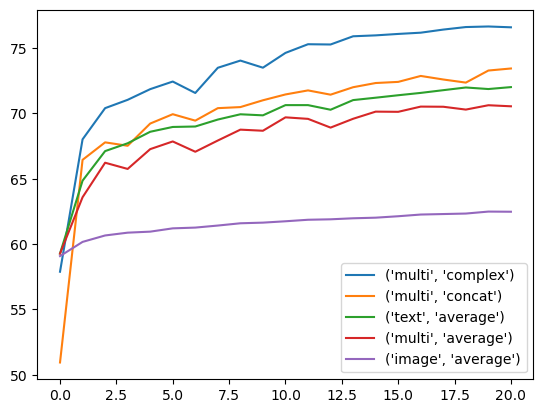

val_acc


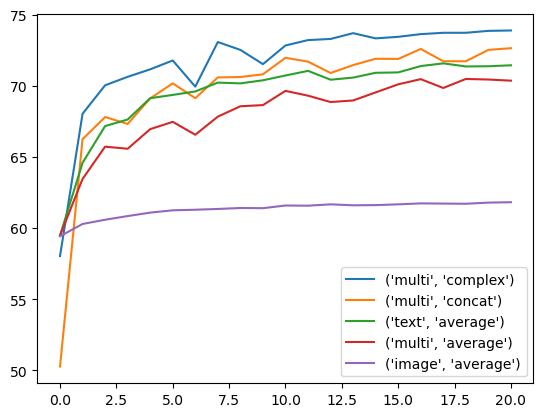

val_img_txt


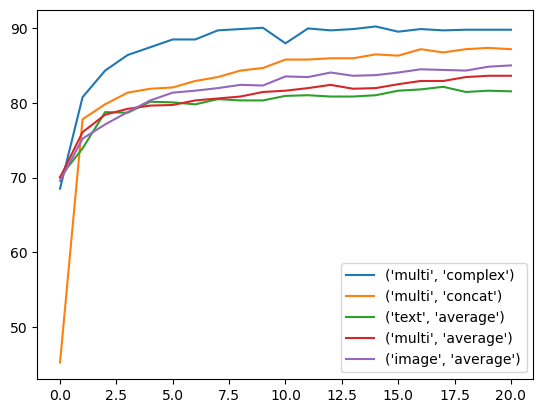

val_txt_only


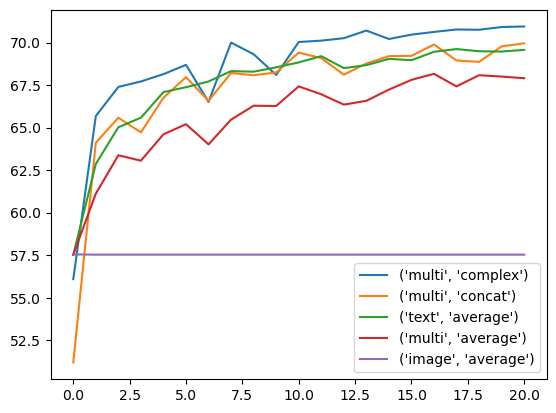

val_unseen_img


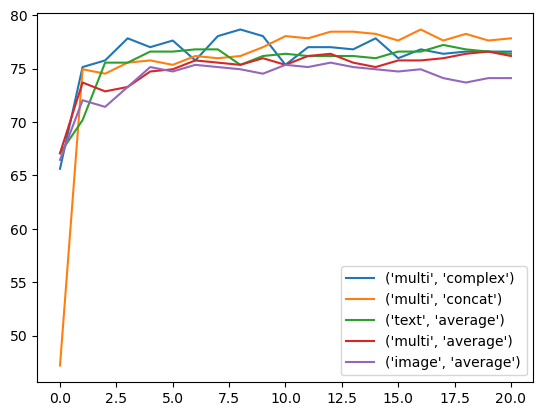

In [35]:
demonstration(hyperdict)

('multi', 'complex')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8095    0.7691    0.7888     29306
         1.0     0.6849    0.7349    0.7090     20010

    accuracy                         0.7552     49316
   macro avg     0.7472    0.7520    0.7489     49316
weighted avg     0.7589    0.7552    0.7564     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8194    0.7763    0.7973     20463
         1.0     0.6975    0.7509    0.7232     14058

    accuracy                         0.7660     34521
   macro avg     0.7585    0.7636    0.7603     34521
weighted avg     0.7698    0.7660    0.7671     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7942    0.7570    0.7752      4400
         1.0     0.6663    0.7120    0.6884      2997

    accuracy                         0.7388      7397
   macro avg     0.7302    0.7345    0.7318

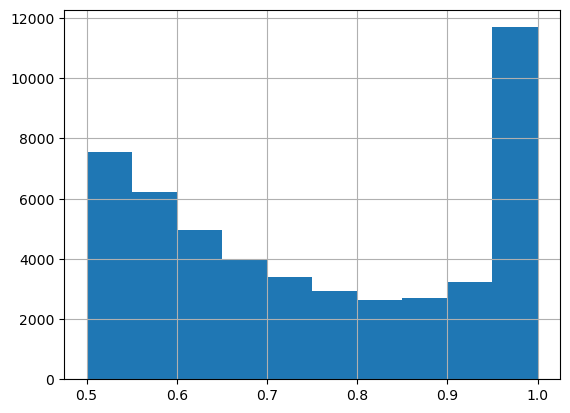

('multi', 'concat')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7685    0.7820    0.7752     29306
         1.0     0.6723    0.6551    0.6636     20010

    accuracy                         0.7305     49316
   macro avg     0.7204    0.7185    0.7194     49316
weighted avg     0.7295    0.7305    0.7299     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7717    0.7839    0.7778     20463
         1.0     0.6780    0.6625    0.6702     14058

    accuracy                         0.7345     34521
   macro avg     0.7249    0.7232    0.7240     34521
weighted avg     0.7336    0.7345    0.7339     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7659    0.7777    0.7718      4400
         1.0     0.6661    0.6510    0.6585      2997

    accuracy                         0.7264      7397
   macro avg     0.7160    0.7144    0.7151 

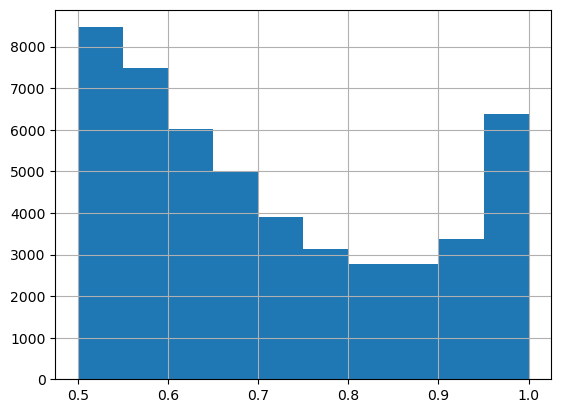

('text', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7681    0.7485    0.7582     29306
         1.0     0.6450    0.6691    0.6568     20010

    accuracy                         0.7163     49316
   macro avg     0.7065    0.7088    0.7075     49316
weighted avg     0.7181    0.7163    0.7170     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7692    0.7486    0.7588     20463
         1.0     0.6478    0.6731    0.6602     14058

    accuracy                         0.7179     34521
   macro avg     0.7085    0.7109    0.7095     34521
weighted avg     0.7198    0.7179    0.7186     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7678    0.7484    0.7580      4400
         1.0     0.6438    0.6677    0.6555      2997

    accuracy                         0.7157      7397
   macro avg     0.7058    0.7080    0.7067 

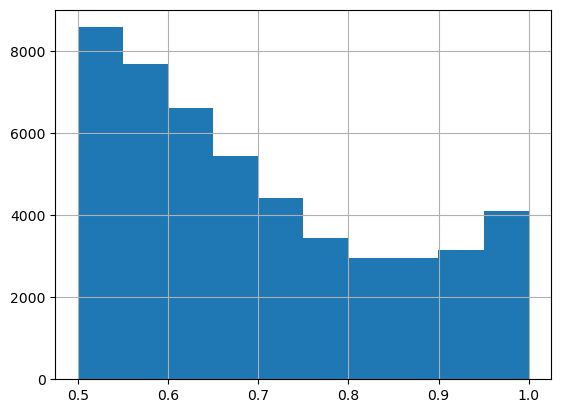

('multi', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8104    0.6518    0.7225     29306
         1.0     0.6037    0.7767    0.6794     20010

    accuracy                         0.7025     49316
   macro avg     0.7071    0.7143    0.7010     49316
weighted avg     0.7266    0.7025    0.7050     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8106    0.6510    0.7221     20463
         1.0     0.6052    0.7786    0.6810     14058

    accuracy                         0.7030     34521
   macro avg     0.7079    0.7148    0.7016     34521
weighted avg     0.7270    0.7030    0.7054     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.8123    0.6550    0.7252      4400
         1.0     0.6056    0.7778    0.6810      2997

    accuracy                         0.7047      7397
   macro avg     0.7090    0.7164    0.7031

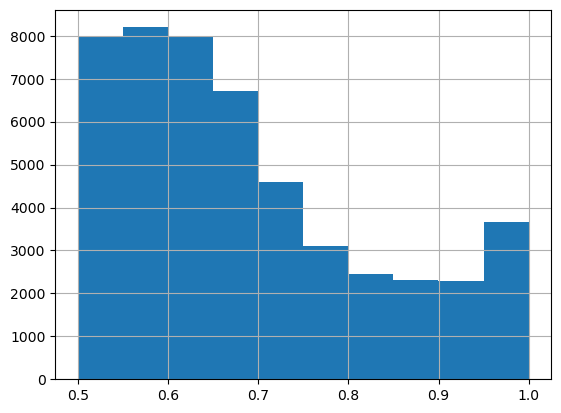

('image', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6135    0.9902    0.7576     29306
         1.0     0.8573    0.0865    0.1571     20010

    accuracy                         0.6235     49316
   macro avg     0.7354    0.5383    0.4573     49316
weighted avg     0.7124    0.6235    0.5139     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6135    0.9922    0.7582     20463
         1.0     0.8883    0.0900    0.1634     14058

    accuracy                         0.6248     34521
   macro avg     0.7509    0.5411    0.4608     34521
weighted avg     0.7254    0.6248    0.5160     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6110    0.9852    0.7542      4400
         1.0     0.7848    0.0791    0.1437      2997

    accuracy                         0.6181      7397
   macro avg     0.6979    0.5322    0.4490

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr


    Overall Accuracy: 62.35
    Training Set Accuracy: 62.48
    Validation Set Accuracy: 61.81
    Validation Set with both Images and Texts: 85.04
    Validation Set with only Texts: 57.53
    Validation Set with unseen Images: 74.12
    
Test Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6135    0.9902    0.7576     29306
         1.0     0.8573    0.0865    0.1571     20010

    accuracy                         0.6235     49316
   macro avg     0.7354    0.5383    0.4573     49316
weighted avg     0.7124    0.6235    0.5139     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6135    0.9922    0.7582     20463
         1.0     0.8883    0.0900    0.1634     14058

    accuracy                         0.6248     34521
   macro avg     0.7509    0.5411    0.4608     34521
weighted avg     0.7254    0.6248    0.5160     34521

Validation Set:
              precision    recall  f1-score   s

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

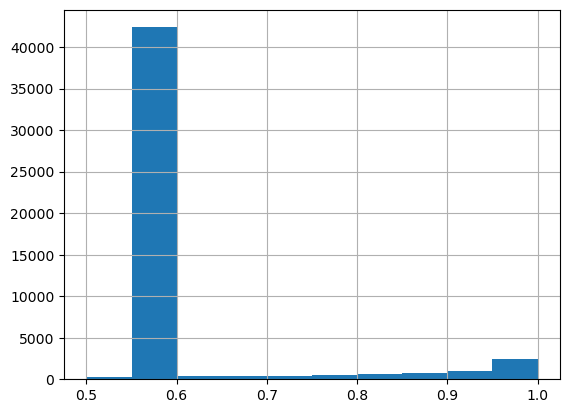

In [37]:
perform_results['O1'] = statistics_F1(hyperdict, stored_data, df, labs, subfolder='001/')

In [38]:
with open(args.save_dir+'002/hyperdict.p', 'rb') as fp:
    hyperdict = pickle.load(fp)

train_acc


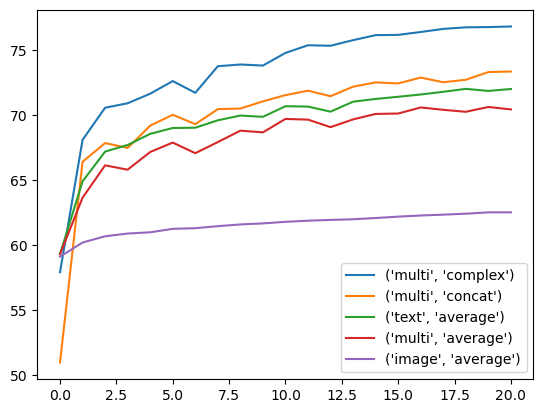

val_acc


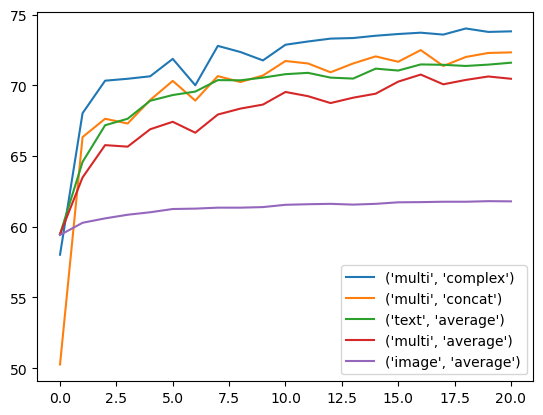

val_img_txt


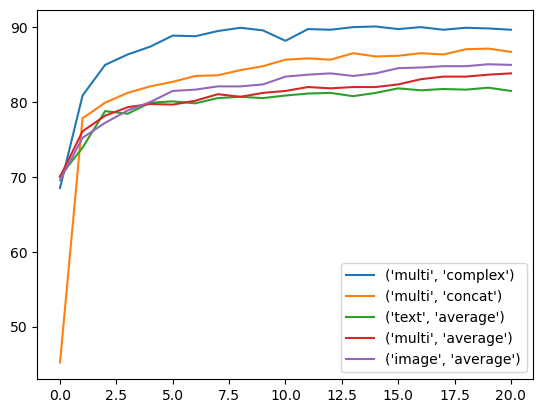

val_txt_only


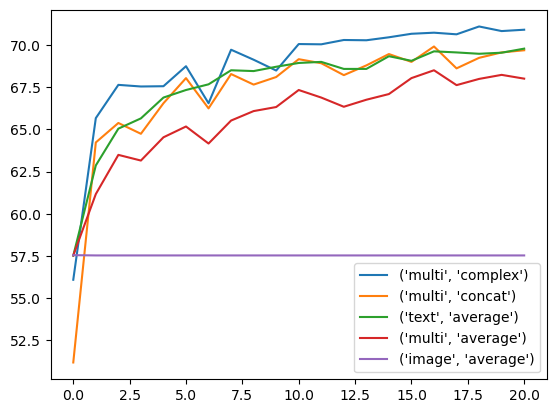

val_unseen_img


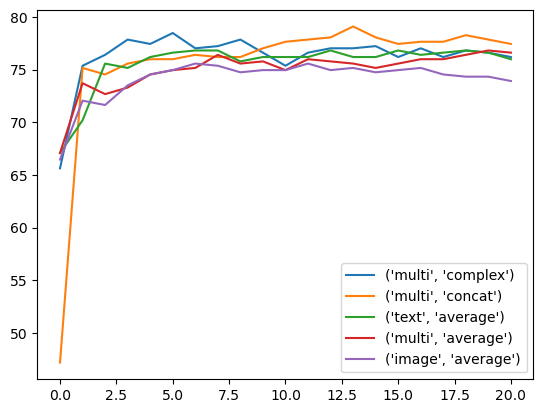

In [39]:
demonstration(hyperdict)

('multi', 'complex')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8132    0.7665    0.7892     29306
         1.0     0.6846    0.7422    0.7122     20010

    accuracy                         0.7566     49316
   macro avg     0.7489    0.7543    0.7507     49316
weighted avg     0.7610    0.7566    0.7579     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8232    0.7736    0.7976     20463
         1.0     0.6970    0.7581    0.7263     14058

    accuracy                         0.7673     34521
   macro avg     0.7601    0.7659    0.7620     34521
weighted avg     0.7718    0.7673    0.7686     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7980    0.7541    0.7754      4400
         1.0     0.6659    0.7197    0.6918      2997

    accuracy                         0.7402      7397
   macro avg     0.7320    0.7369    0.7336

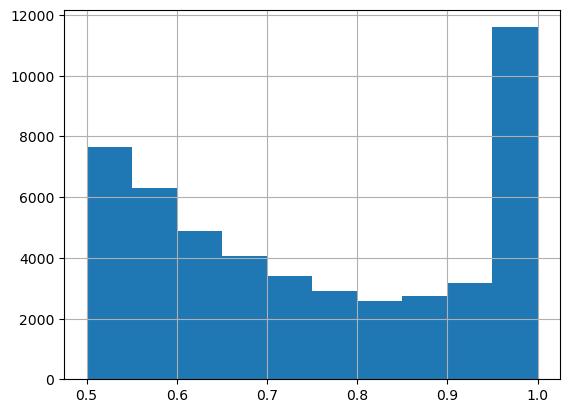

('multi', 'concat')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7784    0.7534    0.7657     29306
         1.0     0.6550    0.6858    0.6701     20010

    accuracy                         0.7260     49316
   macro avg     0.7167    0.7196    0.7179     49316
weighted avg     0.7283    0.7260    0.7269     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7806    0.7542    0.7672     20463
         1.0     0.6590    0.6915    0.6749     14058

    accuracy                         0.7287     34521
   macro avg     0.7198    0.7228    0.7210     34521
weighted avg     0.7311    0.7287    0.7296     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7770    0.7539    0.7653      4400
         1.0     0.6538    0.6823    0.6678      2997

    accuracy                         0.7249      7397
   macro avg     0.7154    0.7181    0.7165 

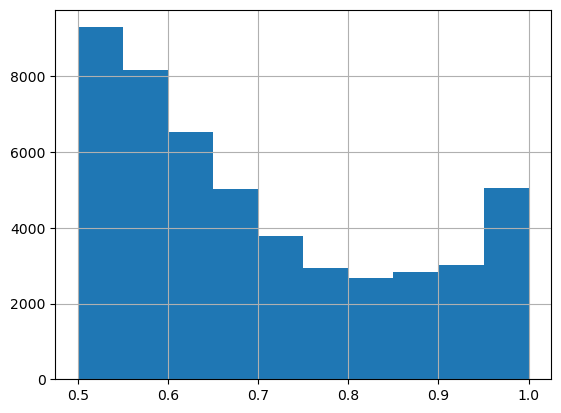

('text', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7561    0.7753    0.7656     29306
         1.0     0.6582    0.6338    0.6458     20010

    accuracy                         0.7179     49316
   macro avg     0.7072    0.7045    0.7057     49316
weighted avg     0.7164    0.7179    0.7170     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7577    0.7754    0.7664     20463
         1.0     0.6615    0.6391    0.6501     14058

    accuracy                         0.7199     34521
   macro avg     0.7096    0.7072    0.7083     34521
weighted avg     0.7185    0.7199    0.7190     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7553    0.7730    0.7640      4400
         1.0     0.6548    0.6323    0.6434      2997

    accuracy                         0.7160      7397
   macro avg     0.7050    0.7026    0.7037 

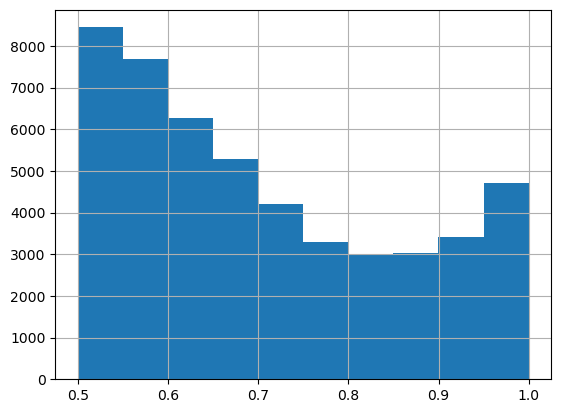

('multi', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7463    0.7648    0.7554     29306
         1.0     0.6425    0.6191    0.6306     20010

    accuracy                         0.7057     49316
   macro avg     0.6944    0.6920    0.6930     49316
weighted avg     0.7042    0.7057    0.7048     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7459    0.7636    0.7546     20463
         1.0     0.6436    0.6213    0.6322     14058

    accuracy                         0.7057     34521
   macro avg     0.6947    0.6925    0.6934     34521
weighted avg     0.7042    0.7057    0.7048     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7467    0.7693    0.7579      4400
         1.0     0.6456    0.6170    0.6310      2997

    accuracy                         0.7076      7397
   macro avg     0.6962    0.6931    0.6944

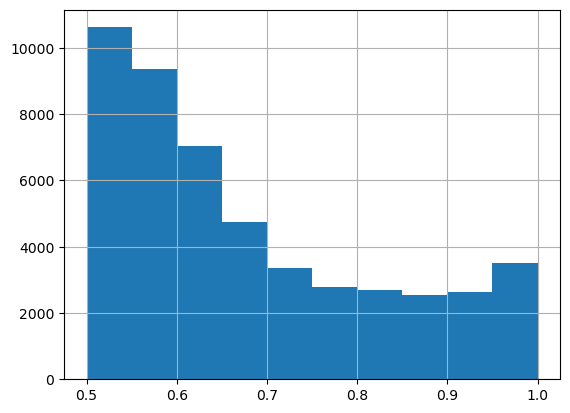

('image', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6139    0.9880    0.7572     29306
         1.0     0.8363    0.0899    0.1623     20010

    accuracy                         0.6236     49316
   macro avg     0.7251    0.5389    0.4598     49316
weighted avg     0.7041    0.6236    0.5158     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6139    0.9900    0.7578     20463
         1.0     0.8652    0.0936    0.1689     14058

    accuracy                         0.6250     34521
   macro avg     0.7395    0.5418    0.4634     34521
weighted avg     0.7162    0.6250    0.5180     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6113    0.9832    0.7539      4400
         1.0     0.7688    0.0821    0.1483      2997

    accuracy                         0.6181      7397
   macro avg     0.6900    0.5326    0.4511

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

Training Set:
              precision    recall  f1-score   support

         0.0     0.6139    0.9900    0.7578     20463
         1.0     0.8652    0.0936    0.1689     14058

    accuracy                         0.6250     34521
   macro avg     0.7395    0.5418    0.4634     34521
weighted avg     0.7162    0.6250    0.5180     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6164    0.9836    0.7579      4443
         1.0     0.7638    0.0799    0.1446      2955

    accuracy                         0.6226      7398
   macro avg     0.6901    0.5317    0.4512      7398
weighted avg     0.6753    0.6226    0.5129      7398

Validation Set with both Images and Texts:
              precision    recall  f1-score   support

         0.0     0.8517    0.8980    0.8742       716
         1.0     0.7638    0.6782    0.7184       348

    accuracy                         0.8261      1064
   macro avg     0.8077    0.7881    0.7963      1064
w

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

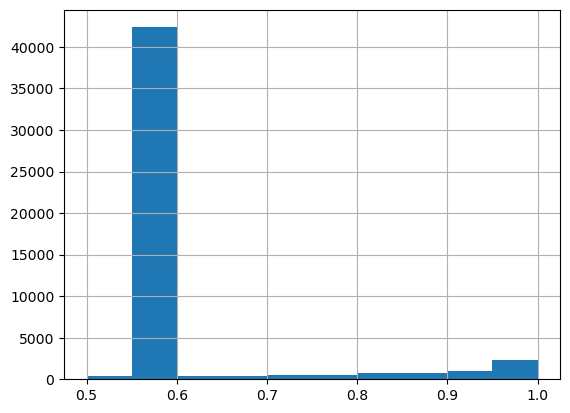

In [40]:
perform_results['O2'] = statistics_F1(hyperdict, stored_data, df, labs, subfolder='002/')

## Zero-shot Classification with Embeddings

In [41]:
embeddings = {}
for v in ['O1', 'O2']:
    embeddings[v] = {}
    for l in ['L2', 'L1', 'L0']:
        embeddings[v][l] = {}
        for t in ['val', 'test']:
            embeddings[v][l][t] = {}

In [42]:
embeddings

{'O1': {'L2': {'val': {}, 'test': {}},
  'L1': {'val': {}, 'test': {}},
  'L0': {'val': {}, 'test': {}}},
 'O2': {'L2': {'val': {}, 'test': {}},
  'L1': {'val': {}, 'test': {}},
  'L0': {'val': {}, 'test': {}}}}

### Option 1

In [43]:
args

Namespace(model_state_file='MLP_classifier.pth', save_dir='model_storage/CLIP_ML_EN/', result_dir='results/CLIP_ML_EN/', embedding_size=512, early_stopping_criteria=20, num_epochs=20, seed=42, batch_size=32, embedding_type='image', fusion_type='average', hidden_dim=128, learning_rate=5e-05, l2=1e-05, dropout_p=0.1, catch_keyboard_interrupt=True, device='cuda', cuda=True, verbose=True)

In [44]:
args.embedding_type = 'multi'
args.fusion_type = 'complex'

In [45]:
classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
classifier.load_state_dict(torch.load(args.save_dir + '001/' + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
classifier.eval()

MLPClassifier(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc_concat): Linear(in_features=1024, out_features=128, bias=True)
  (fc_complex): Linear(in_features=2560, out_features=1024, bias=True)
)

In [46]:
new_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)))))))
new_emb.shape

torch.Size([49316, 128])

In [47]:
labs = {}
labs['txt_emb'] = stored_data['lab_emb']
empty_img_emb = stored_data['empty_img_emb']
labs['img_emb'] = torch.vstack([empty_img_emb] * labs['txt_emb'].shape[0])

In [48]:
labs['img_emb'].shape

torch.Size([2, 512])

In [49]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type)))))))
new_lab_emb.shape

torch.Size([2, 128])

In [50]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L2']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L2']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7936    0.7076    0.7481     29306
         1.0     0.6304    0.7304    0.6767     20010

    accuracy                         0.7168     49316
   macro avg     0.7120    0.7190    0.7124     49316
weighted avg     0.7274    0.7168    0.7191     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8019    0.7198    0.7586     20463
         1.0     0.6450    0.7412    0.6898     14058

    accuracy                         0.7285     34521
   macro avg     0.7235    0.7305    0.7242     34521
weighted avg     0.7380    0.7285    0.7306     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7772    0.6811    0.7260      4400
         1.0     0.6038    0.7134    0.6540      2997

    accuracy                         0.6942      7397
   macro avg     0.6905    0.6973    0

In [51]:
new_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type))))
new_emb.shape

torch.Size([49316, 1024])

In [52]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type))))
new_lab_emb.shape

torch.Size([2, 1024])

In [53]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L1']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L1']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6707    0.8618    0.7543     29306
         1.0     0.6526    0.3803    0.4805     20010

    accuracy                         0.6664     49316
   macro avg     0.6617    0.6210    0.6174     49316
weighted avg     0.6634    0.6664    0.6432     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6702    0.8609    0.7537     20463
         1.0     0.6544    0.3833    0.4835     14058

    accuracy                         0.6664     34521
   macro avg     0.6623    0.6221    0.6186     34521
weighted avg     0.6638    0.6664    0.6436     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6715    0.8675    0.7570      4400
         1.0     0.6597    0.3770    0.4798      2997

    accuracy                         0.6688      7397
   macro avg     0.6656    0.6223    0

In [54]:
new_emb = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
new_emb.shape

torch.Size([49316, 2560])

In [55]:
new_lab_emb = prepare_embedding(labs, args.embedding_type, args.fusion_type)
new_lab_emb.shape

torch.Size([2, 2560])

In [56]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L0']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L0']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6278    0.8635    0.7270     29306
         1.0     0.5560    0.2504    0.3453     20010

    accuracy                         0.6147     49316
   macro avg     0.5919    0.5569    0.5362     49316
weighted avg     0.5987    0.6147    0.5721     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6267    0.8634    0.7262     20463
         1.0     0.5582    0.2513    0.3466     14058

    accuracy                         0.6141     34521
   macro avg     0.5924    0.5573    0.5364     34521
weighted avg     0.5988    0.6141    0.5716     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6275    0.8595    0.7254      4400
         1.0     0.5489    0.2509    0.3444      2997

    accuracy                         0.6130      7397
   macro avg     0.5882    0.5552    0

### Option 2

In [57]:
classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
classifier.load_state_dict(torch.load(args.save_dir + '002/' + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file,map_location=torch.device('cpu')))
classifier.eval()

MLPClassifier(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc_concat): Linear(in_features=1024, out_features=128, bias=True)
  (fc_complex): Linear(in_features=2560, out_features=1024, bias=True)
)

In [58]:
new_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)))))))
new_emb.shape

torch.Size([49316, 128])

In [59]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type)))))))
new_lab_emb.shape

torch.Size([2, 128])

In [60]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L2']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L2']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8377    0.6640    0.7408     29306
         1.0     0.6226    0.8116    0.7046     20010

    accuracy                         0.7239     49316
   macro avg     0.7301    0.7378    0.7227     49316
weighted avg     0.7504    0.7239    0.7261     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8471    0.6764    0.7522     20463
         1.0     0.6358    0.8222    0.7171     14058

    accuracy                         0.7358     34521
   macro avg     0.7414    0.7493    0.7346     34521
weighted avg     0.7610    0.7358    0.7379     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.8239    0.6382    0.7193      4400
         1.0     0.6009    0.7998    0.6862      2997

    accuracy                         0.7037      7397
   macro avg     0.7124    0.7190    0

In [61]:
new_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type))))
new_emb.shape

torch.Size([49316, 1024])

In [62]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type))))
new_lab_emb.shape

torch.Size([2, 1024])

In [63]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L1']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L1']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7417    0.7845    0.7625     29306
         1.0     0.6553    0.5998    0.6263     20010

    accuracy                         0.7096     49316
   macro avg     0.6985    0.6921    0.6944     49316
weighted avg     0.7066    0.7096    0.7072     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7437    0.7869    0.7647     20463
         1.0     0.6611    0.6051    0.6319     14058

    accuracy                         0.7129     34521
   macro avg     0.7024    0.6960    0.6983     34521
weighted avg     0.7101    0.7129    0.7106     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7361    0.7816    0.7582      4400
         1.0     0.6473    0.5886    0.6166      2997

    accuracy                         0.7034      7397
   macro avg     0.6917    0.6851    0

In [64]:
new_emb = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
new_emb.shape

torch.Size([49316, 2560])

In [65]:
new_lab_emb = prepare_embedding(labs, args.embedding_type, args.fusion_type)
new_lab_emb.shape

torch.Size([2, 2560])

In [66]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L0']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L0']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6278    0.8635    0.7270     29306
         1.0     0.5560    0.2504    0.3453     20010

    accuracy                         0.6147     49316
   macro avg     0.5919    0.5569    0.5362     49316
weighted avg     0.5987    0.6147    0.5721     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6267    0.8634    0.7262     20463
         1.0     0.5582    0.2513    0.3466     14058

    accuracy                         0.6141     34521
   macro avg     0.5924    0.5573    0.5364     34521
weighted avg     0.5988    0.6141    0.5716     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6275    0.8595    0.7254      4400
         1.0     0.5489    0.2509    0.3444      2997

    accuracy                         0.6130      7397
   macro avg     0.5882    0.5552    0

In [67]:
results = {}
results['fusion'] = perform_results
results['new_embedding'] = embeddings

In [68]:
import pickle
with open(args.result_dir + 'results_F1.pkl', "wb") as fOut:
    pickle.dump(results, fOut, protocol=pickle.HIGHEST_PROTOCOL)